In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from keras import Model, layers, optimizers, callbacks

from sklearn.model_selection import train_test_split

In [2]:
train_data = pd.read_csv('data/train.csv')
X_test = pd.read_csv('data/test.csv')

X_train = train_data.drop(['label'], axis=1)
y_train = pd.get_dummies(train_data['label'])

total_clf = y_train.shape[1]

In [3]:
X_train = X_train / 255
X_test = X_test / 255

X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

X_train.shape

(42000, 28, 28, 1)

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=31)

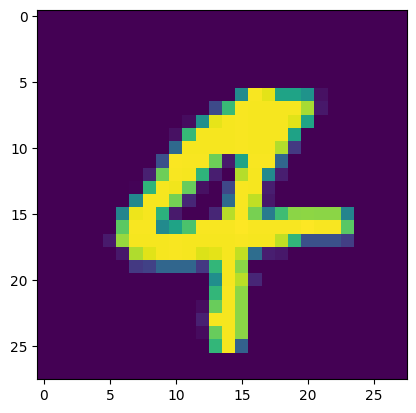

In [5]:
plt.imshow(X_train[0][:,:,0])

In [6]:
in_x = layers.Input(shape=(28,28,1))
x = layers.Conv2D(32, 5, padding='same', activation='relu')(in_x)
x = layers.Conv2D(32, 5, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Dropout(0.25)(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2,2)(x)
x = layers.Dropout(0.25)(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(.5)(x)
out_x = layers.Dense(total_clf, activation='softmax')(x)

model = Model(in_x, out_x)

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                             

In [7]:
reduceLR = callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                       patience=3,
                                       verbose=1,
                                       min_lr=0.00001)

es = callbacks.EarlyStopping(monitor='val_accuracy',
                             patience=5, verbose=1, restore_best_weights=True)

EPOCHS = 10
BATCH_SIZE = 32

In [8]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

dataset = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)

In [9]:
H = model.fit(dataset, epochs=EPOCHS, validation_data=(X_val, y_val), callbacks=[reduceLR, es])

Epoch 1/10
1182/1182 [==============================] - 13s 10ms/step - loss: 0.3606 - accuracy: 0.8860 - val_loss: 0.0420 - val_accuracy: 0.9852 - lr: 0.0010
Epoch 2/10
1182/1182 [==============================] - 11s 9ms/step - loss: 0.1292 - accuracy: 0.9629 - val_loss: 0.0475 - val_accuracy: 0.9850 - lr: 0.0010
Epoch 3/10
1182/1182 [==============================] - 11s 9ms/step - loss: 0.1014 - accuracy: 0.9711 - val_loss: 0.0240 - val_accuracy: 0.9921 - lr: 0.0010
Epoch 4/10
1182/1182 [==============================] - 11s 9ms/step - loss: 0.0990 - accuracy: 0.9728 - val_loss: 0.0389 - val_accuracy: 0.9860 - lr: 0.0010
Epoch 5/10
1182/1182 [==============================] - 12s 10ms/step - loss: 0.0928 - accuracy: 0.9744 - val_loss: 0.0516 - val_accuracy: 0.9881 - lr: 0.0010
Epoch 6/10
1181/1182 [============================>.] - ETA: 0s - loss: 0.0955 - accuracy: 0.9744
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1182/1182 [======================

In [10]:
# predict results
results = model.predict(X_test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

875/875 [==============================] - 2s 2ms/step


In [11]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("data/cnn_mnist.csv",index=False)